# References
- https://www.tensorflow.org/recommenders/examples/basic_retrieval
- https://www.tensorflow.org/recommenders/examples/basic_ranking

# Initial Imports

In [1]:
!pip install -q tensorflow-recommenders


[notice] A new release of pip available: 22.3.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
from typing import Dict, Text

import pandas as pd
import numpy as np
import tensorflow as tf
import random

import tensorflow_recommenders as tfrs

# Loading Data

In [3]:
key='9aadb790'
user_count=1000
generate_count=1000
event_count=400

ratings_df = pd.read_csv(f"https://my.api.mockaroo.com/rating.json?key={key}&count={generate_count}&user_id={user_count}&event_id={event_count}")

# drop duplicated
duplicated_series = ratings_df.duplicated(subset=['user_id', 'event_id'], keep=False)
for row in range(0,len(duplicated_series)):
    if duplicated_series[row] == True:
        ratings_df.drop(index=row, inplace=True)

ratings_df.reset_index(drop=True, inplace=True)

# check for duplicated
duplicated_series = ratings_df.duplicated(subset=['user_id', 'event_id'], keep=False)
for row in range(0,len(duplicated_series)):
    if duplicated_series[row] == True:
        print(row)


ratings_df.to_csv('ratings.csv', sep=',', encoding='utf-8')
ratings = tf.data.Dataset.from_tensor_slices(dict(ratings_df))

In [4]:
events_df = pd.read_csv("events.csv")

non_numeric_cols = events_df.select_dtypes(exclude=['int64', 'float64', 'string']).columns
events_df[non_numeric_cols] = events_df[non_numeric_cols].astype(str)
events_df['interested'] = events_df['interested'].fillna(0).astype(int)

events = tf.data.Dataset.from_tensor_slices(dict(events_df))

In [5]:
print(ratings_df.info(verbose=True))
print(events_df.info(verbose=True))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 998 entries, 0 to 997
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   user_id      998 non-null    int64
 1   user_rating  998 non-null    int64
 2   event_id     998 non-null    int64
dtypes: int64(3)
memory usage: 23.5 KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           400 non-null    int64 
 1   date         400 non-null    object
 2   event_name   400 non-null    object
 3   location     400 non-null    object
 4   description  400 non-null    object
 5   tags         400 non-null    object
 6   interested   400 non-null    int32 
dtypes: int32(1), int64(1), object(5)
memory usage: 20.4+ KB
None


In [6]:
ratings_df.head(3)

,user_id,user_rating,event_id
0,931,4,159
1,103,2,387
2,615,5,10


In [7]:
events_df.head(3)

,id,date,event_name,location,description,tags,interested
0,1,"Wed, 24 - Fri, 26 May 2023",Tyre & Rubber Indonesia,Jakarta,The Tyre & Rubber Indonesia is the only dedica...,"['Tradeshow', 'Auto & Automotive', 'Rubber & T...",304
1,2,"Wed, 24 - Fri, 26 May 2023","Indonesia International Construction, Infrastr...",Jakarta,Con-Mine – GET your ultimate business chances ...,"['Tradeshow', 'Building & Construction']",102
2,3,"Sun, 11 - Wed, 14 Jun 2023",ICM Triennial Congress,Bali,It will be six years since our last in-person ...,"['Conference', 'Medical & Pharma', 'Investment']",35


In [8]:
processed_df = pd.merge(ratings_df, events_df, left_on='event_id', right_on='id')
processed_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 998 entries, 0 to 997
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   user_id      998 non-null    int64 
 1   user_rating  998 non-null    int64 
 2   event_id     998 non-null    int64 
 3   id           998 non-null    int64 
 4   date         998 non-null    object
 5   event_name   998 non-null    object
 6   location     998 non-null    object
 7   description  998 non-null    object
 8   tags         998 non-null    object
 9   interested   998 non-null    int32 
dtypes: int32(1), int64(4), object(5)
memory usage: 74.2+ KB


In [9]:
processed_df = pd.merge(ratings_df, events_df, left_on='event_id', right_on='id')
location_df = pd.get_dummies(processed_df['location'])
location_df.rename(columns=lambda x: f'location_{x}'.lower().replace(' ', '_'), inplace=True)
processed_df = processed_df.drop(['id','date','description','interested','location','tags'],axis=1)
processed_df = pd.concat([processed_df, location_df],axis=1)
processed_df.head(3)
processed_df.columns

Index(['user_id', 'user_rating', 'event_id', 'event_name', 'location_andir',
       'location_bali', 'location_balikpapan', 'location_balikpapan_kota',
       'location_banda_aceh', 'location_bandung', 'location_bantul',
       'location_batam', 'location_baturiti', 'location_bogor',
       'location_cempaka_putih', 'location_central_semarang', 'location_dau',
       'location_depok', 'location_east_bekasi', 'location_east_palu',
       'location_gabek', 'location_girsang_sipangan_bolon_sub',
       'location_jakarta', 'location_jember', 'location_kasihan',
       'location_kelapa_gading', 'location_kramatjati', 'location_kuta',
       'location_lowokwaru', 'location_lubuk_kilangan', 'location_makassar',
       'location_malang', 'location_medan', 'location_mulyorejo',
       'location_ngemplak', 'location_north_bekasi', 'location_palembang',
       'location_pancoran', 'location_pasar_minggu', 'location_pekanbaru',
       'location_pesanggrahan', 'location_prigen', 'location_purwokert

In [10]:
ratings = tf.data.Dataset.from_tensor_slices(dict(processed_df))
events = tf.data.Dataset.from_tensor_slices(dict(processed_df)).map(lambda x: x["event_id"])

In [11]:
tf.random.set_seed(42)
shuffled = ratings.shuffle(100_000, seed=42, reshuffle_each_iteration=False)
n = tf.data.experimental.cardinality(shuffled)

train = shuffled.take(int(n*4/5))
test = shuffled.skip(int(n*4/5)).take(int(n*1/5))

In [12]:
event_names = events.batch(1_000)
user_ids = ratings.batch(1_000_000).map(lambda x: x["user_id"])

unique_event_ids = np.unique(np.concatenate(list(event_names)))
unique_user_ids = np.unique(np.concatenate(list(user_ids)))

print(unique_event_ids[:5])
print(unique_user_ids[:5])

[1 2 3 4 5]
[1 5 6 8 9]


# Creating Models

## Retrieval Model

In [79]:
embedding_dimension = 32
# Add an additional embedding to account for unknown tokens.
# Candidate tower
event_model = tf.keras.Sequential([
    tf.keras.layers.IntegerLookup(vocabulary=unique_event_ids, mask_token=None),
    tf.keras.layers.Embedding(len(unique_event_ids) + 1, embedding_dimension)
])

# Query tower
user_model = tf.keras.Sequential([
    tf.keras.layers.IntegerLookup(vocabulary=unique_user_ids, mask_token=None),
    tf.keras.layers.Embedding(len(unique_user_ids) + 1, embedding_dimension)
])

class RetrievalModel(tfrs.Model):

  def __init__(self):
    super().__init__()
    self.event_model: tf.keras.Model = event_model
    self.user_model: tf.keras.Model = user_model
    self.task: tf.keras.layers.Layer = tfrs.tasks.Retrieval(
      metrics = tfrs.metrics.FactorizedTopK(
        candidates=events.batch(128).map(event_model)
        ))

  def compute_loss(self, features: Dict[Text, tf.Tensor], training=False) -> tf.Tensor:
    user_embeddings = self.user_model(features["user_id"])
    positive_event_embeddings = self.event_model(features["event_id"])

    # parameter: query embedding, candidate embedding.
    return self.task(user_embeddings, positive_event_embeddings)

## Ranking Model

In [308]:
class RankingModel(tf.keras.Model):

  def __init__(self):
    super().__init__()
    self.user_embeddings = user_model
    self.event_embeddings = event_model

    self.ratings = tf.keras.Sequential([
      tf.keras.layers.Dense(256, activation="relu"),
      tf.keras.layers.Dense(64, activation="relu"),
      tf.keras.layers.Dense(1)
  ])
  
  def call(self, inputs):
    user_id, event_id = inputs

    user_embedding = self.user_embeddings(user_id)
    event_embedding = self.event_embeddings(event_id)

    # predict rating that the user would give to the event
    return self.ratings(tf.concat([user_embedding, event_embedding], axis=1))

class EventModel(tfrs.models.Model):

  def __init__(self):
    super().__init__()
    self.ranking_model: tf.keras.Model = RankingModel()
    self.task: tf.keras.layers.Layer = tfrs.tasks.Ranking(
      loss = tf.keras.losses.MeanSquaredError(),
      metrics=[tf.keras.metrics.RootMeanSquaredError()]
    )

  # Call what model to use when making prediction
  def call(self, features: Dict[str, tf.Tensor]) -> tf.Tensor:
    return self.ranking_model(
        (features["user_id"], features["event_id"]))

  def compute_loss(self, features: Dict[Text, tf.Tensor], training=False) -> tf.Tensor:
    # pop rating as the target label
    labels = features.pop("user_rating")
    
    rating_predictions = self(features)

    # The task computes the loss and the metrics.
    return self.task(labels=labels, predictions=rating_predictions)

In [137]:
processed_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 998 entries, 0 to 997
Data columns (total 55 columns):
 #   Column                               Non-Null Count  Dtype 
---  ------                               --------------  ----- 
 0   user_id                              998 non-null    int64 
 1   user_rating                          998 non-null    int64 
 2   event_id                             998 non-null    int64 
 3   event_name                           998 non-null    object
 4   location_andir                       998 non-null    bool  
 5   location_bali                        998 non-null    bool  
 6   location_balikpapan                  998 non-null    bool  
 7   location_balikpapan_kota             998 non-null    bool  
 8   location_banda_aceh                  998 non-null    bool  
 9   location_bandung                     998 non-null    bool  
 10  location_bantul                      998 non-null    bool  
 11  location_batam                       998 non-

In [138]:
# user id + event id = predicted rating
user_ids, event_ids = np.array([99 for i in range(1000)]), np.array([random.randint(1,event_count+1) for i in range(1000)])
predicted_list = list(np.concatenate(RankingModel()((user_ids, event_ids)).numpy()))
predicted_event_id = predicted_list.index(max(predicted_list))
print(f'predicted event id: {predicted_event_id}')
print(f'highest score: {max(predicted_list)}')

predicted event id: 183
highest score: 0.0210011787712574


# Model Fitting, Evaluating, Predicting

## Retrieval Model

### Fitting and evaluating

After defining the model, we can use standard Keras fitting and evaluation routines to fit and evaluate the model.

Let's first instantiate the model.

In [139]:
retrieval_model = RetrievalModel()
retrieval_model.compile(optimizer=tf.keras.optimizers.Adagrad(learning_rate=0.1))
cached_train = train.shuffle(100_000).batch(8192).cache()
cached_test = test.batch(4096).cache()

retrieval_model.fit(cached_train, epochs=10)

Epoch 1/10
1/1 [==============================] - 1s 651ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0288 - factorized_top_k/top_100_categorical_accuracy: 0.0865 - loss: 5332.3374 - regularization_loss: 0.0000e+00 - total_loss: 5332.3374
Epoch 2/10
1/1 [==============================] - 0s 97ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0602 - factorized_top_k/top_10_categorical_accuracy: 0.1516 - factorized_top_k/top_50_categorical_accuracy: 0.6792 - factorized_top_k/top_100_categorical_accuracy: 0.8534 - loss: 5319.2808 - regularization_loss: 0.0000e+00 - total_loss: 5319.2808
Epoch 3/10
1/1 [==============================] - 0s 99ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical

In [140]:
retrieval_model.evaluate(cached_test, return_dict=True)

1/1 [==============================] - 0s 372ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0050 - factorized_top_k/top_10_categorical_accuracy: 0.0101 - factorized_top_k/top_50_categorical_accuracy: 0.0201 - factorized_top_k/top_100_categorical_accuracy: 0.0754 - loss: 1094.1486 - regularization_loss: 0.0000e+00 - total_loss: 1094.1486


{'factorized_top_k/top_1_categorical_accuracy': 0.0,
 'factorized_top_k/top_5_categorical_accuracy': 0.005025125574320555,
 'factorized_top_k/top_10_categorical_accuracy': 0.01005025114864111,
 'factorized_top_k/top_50_categorical_accuracy': 0.02010050229728222,
 'factorized_top_k/top_100_categorical_accuracy': 0.07537688314914703,
 'loss': 1094.1485595703125,
 'regularization_loss': 0,
 'total_loss': 1094.1485595703125}

Why test performance is bad:
- The model is re-recommending some events that the users' already rated. These can crowd out test movies out of top K recommendations.
    - In some cases, re-recommending past things is good.

### Making predictions

Now that we have a retrieval_model, we would like to be able to make predictions. We can use the `tfrs.layers.factorized_top_k.BruteForce` layer to do this.

In [37]:
user_id = random.choice(processed_df['user_id'])
processed_df.loc[processed_df['user_id']==user_id]

,user_id,user_rating,event_id,event_name,location_andir,location_bali,location_balikpapan,location_balikpapan_kota,location_banda_aceh,location_bandung,...,location_sukajadi,location_sukasari,location_sumbersari,location_surabaya,location_surakarta,location_tangerang,location_ubud,location_west_denpasar,location_west_semarang,location_yogyakarta
137,552,5,203,Print For Pack,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
447,552,5,54,Indonesia Digital Technology Expo (INDITEX),False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
858,552,4,81,"International Conference on Agriculture, Fores...",False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [38]:
# Create a model that takes in raw query features, and
index = tfrs.layers.factorized_top_k.BruteForce(retrieval_model.user_model, k=10)
# recommends events out of the entire events dataset.
index.index_from_dataset(
  tf.data.Dataset.zip((events.batch(100), events.batch(100).map(retrieval_model.event_model)))
)

# Get k recommendations. INPUT MUST HAVE AT LEAST K ITEMS
key, titles = index(tf.constant([user_id]))
print(f"Recommendations for user {user_id}: {[str(i.numpy()) for i in titles[0, :]]}")

Recommendations for user 552: ['81', '81', '81', '39', '39', '39', '39', '397', '397', '319']


## Ranking Model

In [39]:
cached_train = train.shuffle(100_000).batch(8192).cache()
cached_test = test.batch(4096).cache()

In [169]:
import matplotlib.pyplot as plt

ranking_model = EventModel()

def evaluate_model(model, train_data, test_data, min_epoch, max_epoch):
    epochs = range(min_epoch, max_epoch+1)
    optimizers = [
        tf.keras.optimizers.Adadelta(),
        tf.keras.optimizers.Adafactor(),
        tf.keras.optimizers.Adagrad(),
        tf.keras.optimizers.Adamax(),
        tf.keras.optimizers.Adam(),
        tf.keras.optimizers.Ftrl(),
        tf.keras.optimizers.Nadam(),
        tf.keras.optimizers.SGD(),
        tf.keras.optimizers.RMSprop(),
    ]
    for optimizer in optimizers:
        train_losses = []
        test_losses = []
        model.compile(optimizer=optimizer)

        for epoch in epochs:
            model.fit(train_data, epochs=epoch, verbose=0)
            train_loss = model.evaluate(train_data, verbose=0, return_dict=True)['loss']
            test_loss = model.evaluate(test_data, verbose=0, return_dict=True)['loss']
            train_losses.append(train_loss)
            test_losses.append(test_loss)

        plt.figure(figsize=(4,3))
        plt.plot(epochs, train_losses, label='Train Loss')
        plt.plot(epochs, test_losses, label='Test Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title(f'Ranking Model Evaluation: {optimizer.name}')
        plt.legend()
        for epoch in epochs:
            plt.axvline(x=epoch, color='gray', linestyle='--', linewidth=0.5)
        plt.xticks(ticks=epochs)
        plt.show()
        model.reset_states()

# Assuming you have initialized 'ranking_model', 'cached_train', and 'cached_test' variables

min_epoch = 5  # Specify the minimum epoch
max_epoch = 20  # Specify the maximum epoch

evaluate_model(ranking_model, cached_train, cached_test, min_epoch, max_epoch)


KeyboardInterrupt: 

### Choose fitting epoch number

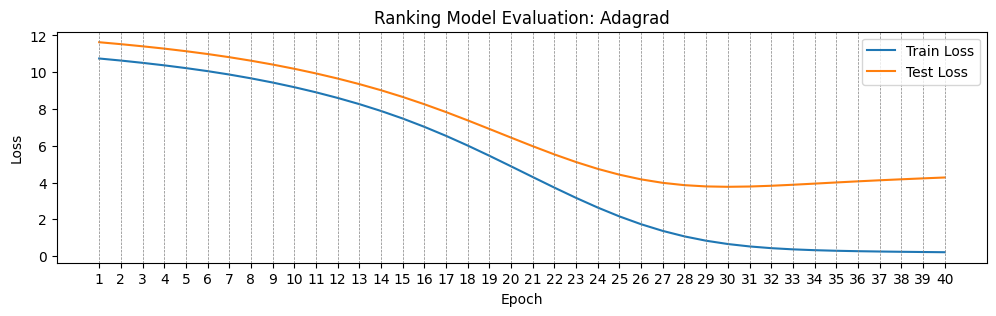

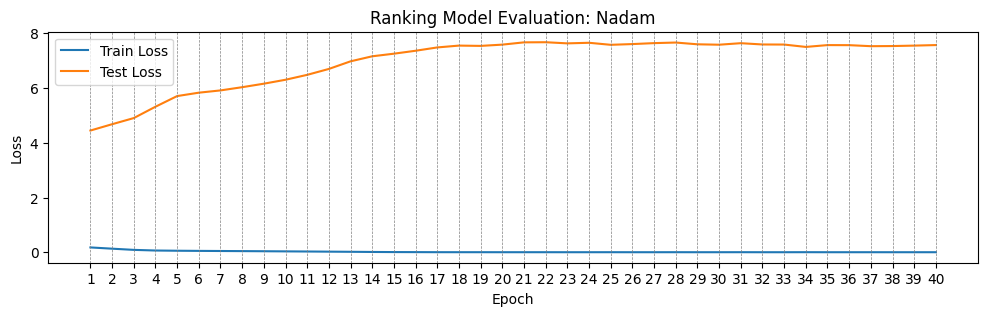

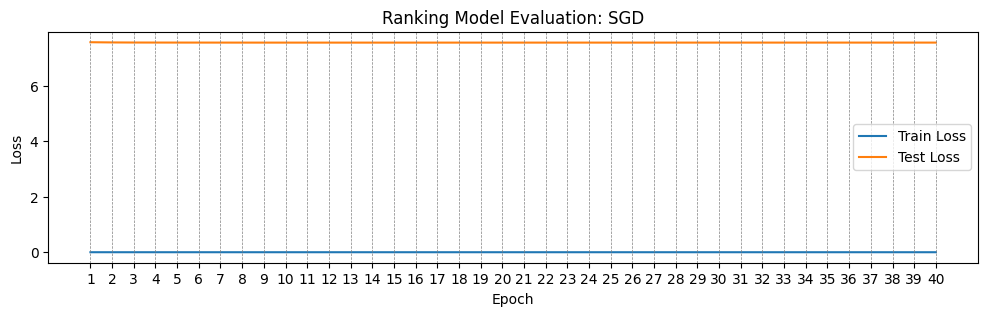

In [78]:
import matplotlib.pyplot as plt

ranking_model = EventModel()

def evaluate_model(model, train_data, test_data, min_epoch, max_epoch):
    epochs = range(min_epoch, max_epoch+1)
    optimizers = [
        tf.keras.optimizers.Adagrad(),
        tf.keras.optimizers.Nadam(),
        tf.keras.optimizers.SGD()
    ]
    for optimizer in optimizers:
        train_losses = []
        test_losses = []
        model.compile(optimizer=optimizer)

        for epoch in epochs:
            model.fit(train_data, epochs=epoch, verbose=0)
            train_loss = model.evaluate(train_data, verbose=0, return_dict=True)['loss']
            test_loss = model.evaluate(test_data, verbose=0, return_dict=True)['loss']
            train_losses.append(train_loss)
            test_losses.append(test_loss)

        plt.figure(figsize=(12,3))
        plt.plot(epochs, train_losses, label='Train Loss')
        plt.plot(epochs, test_losses, label='Test Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title(f'Ranking Model Evaluation: {optimizer.name}')
        plt.legend()
        for epoch in epochs:
            plt.axvline(x=epoch, color='gray', linestyle='--', linewidth=0.5)
        plt.xticks(ticks=epochs)
        plt.show()
        model.reset_states()

# Assuming you have initialized 'ranking_model', 'cached_train', and 'cached_test' variables

min_epoch = 1  # Specify the minimum epoch
max_epoch = 40  # Specify the maximum epoch

evaluate_model(ranking_model, cached_train, cached_test, min_epoch, max_epoch)


### Choose learning rate

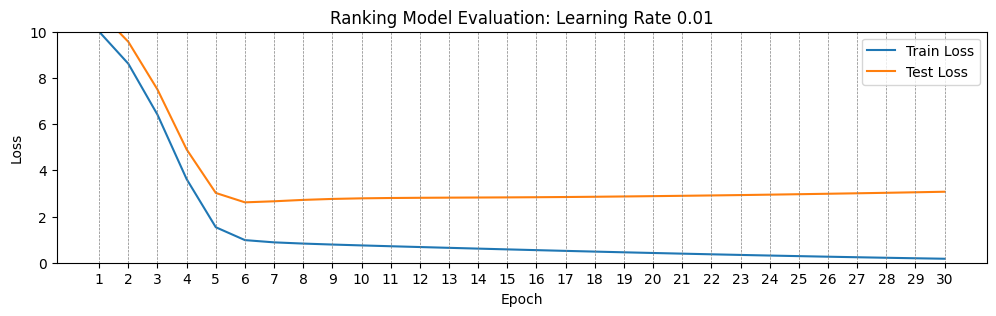

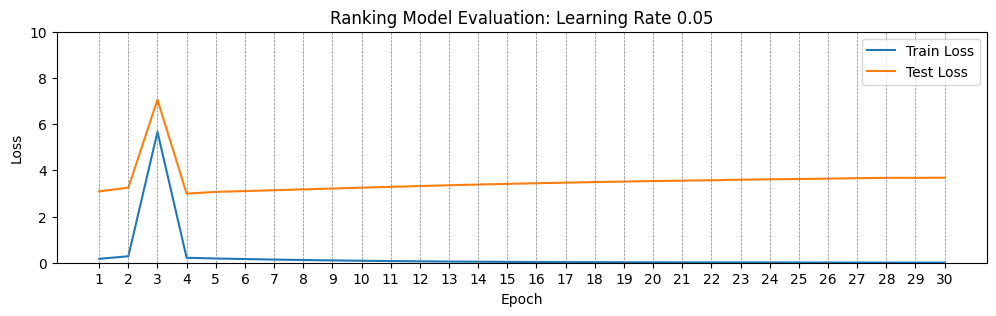

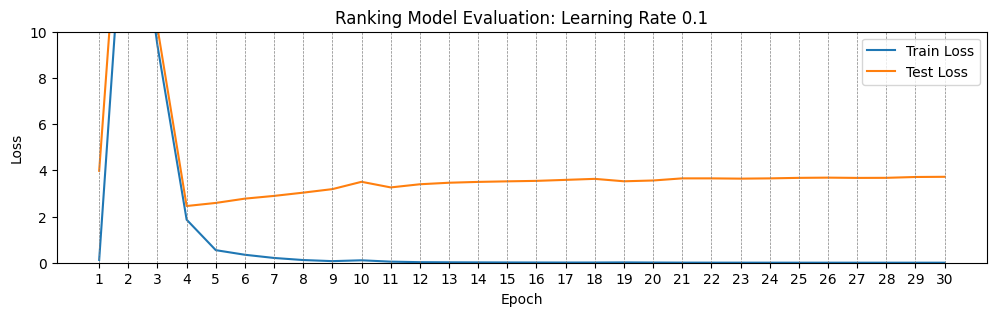

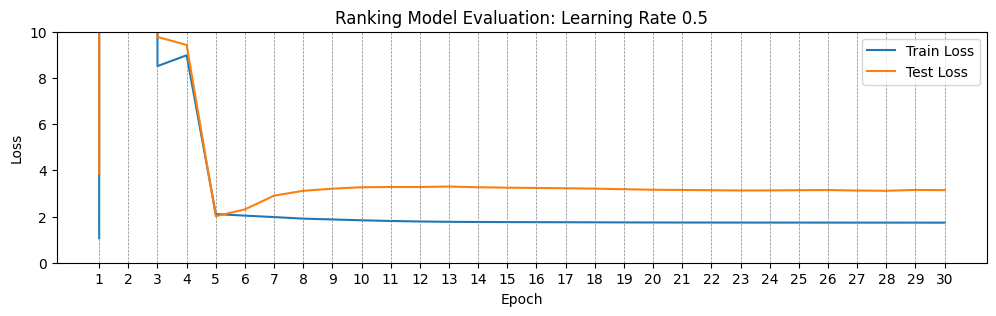

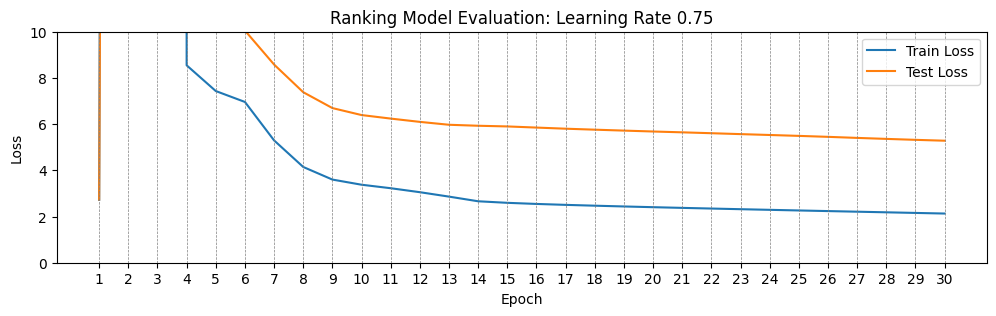

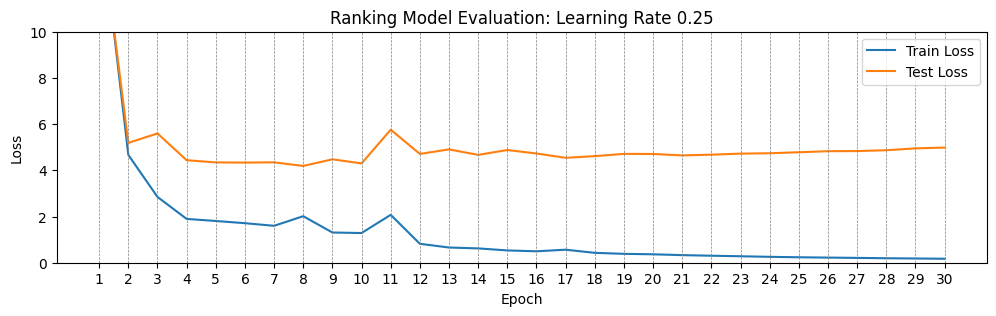

In [81]:
import matplotlib.pyplot as plt

ranking_model = EventModel()

def evaluate_model(model, train_data, test_data, min_epoch, max_epoch):
    epochs = range(min_epoch, max_epoch+1)
    learning_rates = [0.01,0.05,0.1,0.5,0.75,0.25]
    for learning_rate in learning_rates:
        train_losses = []
        test_losses = []
        model.compile(optimizer=tf.keras.optimizers.Adagrad(learning_rate=learning_rate))

        for epoch in epochs:
            model.fit(train_data, epochs=epoch, verbose=0)
            train_loss = model.evaluate(train_data, verbose=0, return_dict=True)['loss']
            test_loss = model.evaluate(test_data, verbose=0, return_dict=True)['loss']
            train_losses.append(train_loss)
            test_losses.append(test_loss)

        plt.figure(figsize=(12,3))
        plt.plot(epochs, train_losses, label='Train Loss')
        plt.plot(epochs, test_losses, label='Test Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title(f'Ranking Model Evaluation: Learning Rate {learning_rate}')
        plt.legend()
        for epoch in epochs:
            plt.axvline(x=epoch, color='gray', linestyle='--', linewidth=0.5)
        plt.xticks(ticks=epochs)
        plt.ylim(bottom=0, top=10)
        plt.show()
        model.reset_states()

# Assuming you have initialized 'ranking_model', 'cached_train', and 'cached_test' variables

min_epoch = 1  # Specify the minimum epoch
max_epoch = 30  # Specify the maximum epoch

evaluate_model(ranking_model, cached_train, cached_test, min_epoch, max_epoch)


# Choose Epoch for chosen learning rate

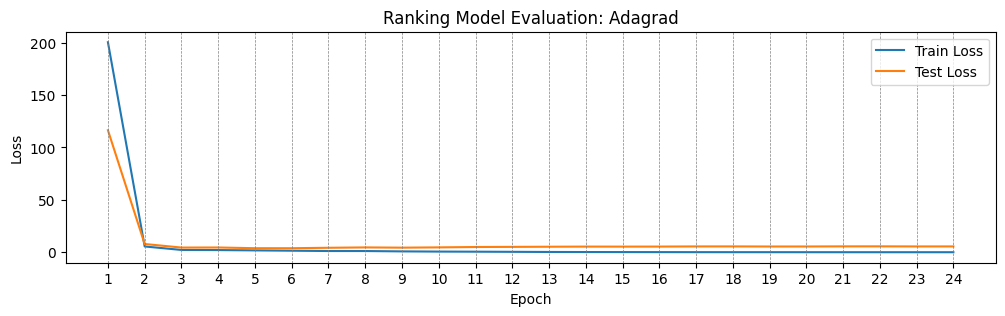

In [82]:
import matplotlib.pyplot as plt

ranking_model = EventModel()

def evaluate_model(model, train_data, test_data, min_epoch, max_epoch):
    epochs = range(min_epoch, max_epoch+1)
    optimizers = [
        tf.keras.optimizers.Adagrad(learning_rate=0.05)
    ]
    for optimizer in optimizers:
        train_losses = []
        test_losses = []
        model.compile(optimizer=optimizer)

        for epoch in epochs:
            model.fit(train_data, epochs=epoch, verbose=0)
            train_loss = model.evaluate(train_data, verbose=0, return_dict=True)['loss']
            test_loss = model.evaluate(test_data, verbose=0, return_dict=True)['loss']
            train_losses.append(train_loss)
            test_losses.append(test_loss)

        plt.figure(figsize=(12,3))
        plt.plot(epochs, train_losses, label='Train Loss')
        plt.plot(epochs, test_losses, label='Test Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title(f'Ranking Model Evaluation: {optimizer.name}')
        plt.legend()
        for epoch in epochs:
            plt.axvline(x=epoch, color='gray', linestyle='--', linewidth=0.5)
        plt.xticks(ticks=epochs)
        plt.show()
        model.reset_states()

# Assuming you have initialized 'ranking_model', 'cached_train', and 'cached_test' variables

min_epoch = 1  # Specify the minimum epoch
max_epoch = 24  # Specify the maximum epoch

evaluate_model(ranking_model, cached_train, cached_test, min_epoch, max_epoch)


In [21]:
for _ in range(10):
    ranking_model = EventModel()
    ranking_model.compile(optimizer=tf.keras.optimizers.Adagrad(learning_rate=0.05))
    ranking_model.fit(cached_train, epochs=5, verbose=0)
    print(ranking_model.evaluate(cached_test, return_dict=True))

1/1 [==============================] - 0s 134ms/step - root_mean_squared_error: 1.7371 - loss: 3.0174 - regularization_loss: 0.0000e+00 - total_loss: 3.0174
{'root_mean_squared_error': 1.7370712757110596, 'loss': 3.017416477203369, 'regularization_loss': 0, 'total_loss': 3.017416477203369}
1/1 [==============================] - 0s 81ms/step - root_mean_squared_error: 1.7284 - loss: 2.9873 - regularization_loss: 0.0000e+00 - total_loss: 2.9873
{'root_mean_squared_error': 1.7283755540847778, 'loss': 2.9872820377349854, 'regularization_loss': 0, 'total_loss': 2.9872820377349854}
1/1 [==============================] - 0s 83ms/step - root_mean_squared_error: 1.7173 - loss: 2.9491 - regularization_loss: 0.0000e+00 - total_loss: 2.9491
{'root_mean_squared_error': 1.7173004150390625, 'loss': 2.94912052154541, 'regularization_loss': 0, 'total_loss': 2.94912052154541}
1/1 [==============================] - 0s 81ms/step - root_mean_squared_error: 1.7566 - loss: 3.0858 - regularization_loss: 0.000

# Finalize model

In [309]:
ranking_model = EventModel()
ranking_model.compile(optimizer=tf.keras.optimizers.Adagrad(learning_rate=0.05))
ranking_model.fit(cached_train, epochs=4, verbose=0)

In [296]:
user_id = random.choice(processed_df['user_id'])
processed_df.loc[processed_df['user_id']==user_id]

,user_id,user_rating,event_id,event_name,location_andir,location_bali,location_balikpapan,location_balikpapan_kota,location_banda_aceh,location_bandung,...,location_sukajadi,location_sukasari,location_sumbersari,location_surabaya,location_surakarta,location_tangerang,location_ubud,location_west_denpasar,location_west_semarang,location_yogyakarta
236,326,5,301,Enterprise Risk Management (ERM),False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
678,326,5,201,ICCIM : The Third International Conference of ...,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [338]:
import itertools

test_ratings = {}
test_event_ids = np.unique(processed_df['event_id'])
for event_id in test_event_ids:
  test_ratings[event_id] = ranking_model({
      "user_id": np.array([user_id]),
      "event_id": np.array([event_id])
  })

print("Ratings Desc:")
for id, score in itertools.islice(sorted(test_ratings.items(), key=lambda x: x[1][0][0], reverse=True),10):
  title = id
  print(f"{title}: {score[0][0]}")

print()

print("Ratings Asc:")
for id, score in itertools.islice(sorted(test_ratings.items(), key=lambda x: x[1][0][0]),10):
  title = id
  print(f"{title}: {score[0][0]}")

Ratings Desc:
158: 3.860995292663574
270: 3.719954252243042
234: 3.601200819015503
325: 3.5105786323547363
268: 3.508910655975342
4: 3.4810500144958496
384: 3.479726552963257
386: 3.476735830307007
381: 3.4726409912109375
255: 3.4653255939483643

Ratings Asc:
138: 2.2082390785217285
116: 2.2317702770233154
202: 2.231898784637451
392: 2.2433977127075195
179: 2.2488958835601807
82: 2.2521073818206787
54: 2.255450487136841
49: 2.2577757835388184
3: 2.2600066661834717
389: 2.2612593173980713


In [181]:
list(sorted(test_ratings.items(), key=lambda x: x[1][0][0], reverse=True))

[(381,
  <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[2.2001734]], dtype=float32)>),
 (275,
  <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[2.1453497]], dtype=float32)>),
 (93,
  <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[2.0504804]], dtype=float32)>),
 (244,
  <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[1.9325135]], dtype=float32)>),
 (359,
  <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[1.9219897]], dtype=float32)>),
 (294,
  <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[1.8883127]], dtype=float32)>),
 (15,
  <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[1.8798053]], dtype=float32)>),
 (119,
  <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[1.8632818]], dtype=float32)>),
 (388,
  <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[1.8542522]], dtype=float32)>),
 (159,
  <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[1.842117]], dtype=float32)>),
 (205,
  <tf.Tensor: shape=(1, 1), dtype=float32, num

# Model Serving

## Retrieval Model

After the model is trained, we need a way to deploy it.

In a two-tower retrieval model, serving has two components:

- a serving query model, taking in features of the query and transforming them into a query embedding, and
- a serving candidate model. This most often takes the form of an approximate nearest neighbours (ANN) index which allows fast approximate lookup of candidates in response to a query produced by the query model.

In [311]:
user_id = random.choice(processed_df['user_id'])
processed_df.loc[processed_df['user_id']==user_id]

,user_id,user_rating,event_id,event_name,location_andir,location_bali,location_balikpapan,location_balikpapan_kota,location_banda_aceh,location_bandung,...,location_sukajadi,location_sukasari,location_sumbersari,location_surabaya,location_surakarta,location_tangerang,location_ubud,location_west_denpasar,location_west_semarang,location_yogyakarta
370,910,3,241,IEOM Annual International Conference,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [312]:
# path = os.path.join(tmp, "model")
path = "./retrieval_model"

# Save the index.
tf.saved_model.save(index, path)

# Load it back; can also be done in TensorFlow Serving.
loaded = tf.saved_model.load(path)

# Pass a user id in, get top predicted event titles back.
scores, titles = loaded([user_id])

INFO:tensorflow:Assets written to: ./retrieval_model\assets


INFO:tensorflow:Assets written to: ./retrieval_model\assets


In [313]:
[i.numpy() for i in titles[0]]

[241, 241, 241, 241, 241, 241, 241, 16, 16, 16]

## Ranking Model

In [334]:
loaded.ranking_model((
    tf.constant([user_id], dtype=tf.int64),
    tf.constant([event_id], dtype=tf.int64)
    ))

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[3.4500563]], dtype=float32)>

In [345]:
import itertools

path = "./ranking_model"
tf.saved_model.save(ranking_model, path)
ranking_model.save(path)
loaded = tf.saved_model.load(path)

test_ratings = {}
test_event_ids = [random.randint(1,event_count+1) for i in range(1000)]
for event_id in test_event_ids:
  test_ratings[event_id] = loaded.ranking_model((
    tf.constant([user_id], dtype=tf.int64),
    tf.constant([event_id], dtype=tf.int64)
    ))

print("Ratings Desc:")
for id, score in itertools.islice(sorted(test_ratings.items(), key=lambda x: x[1][0][0], reverse=True),10):
  title = id
  print(f"{title}: {score[0][0]}")

print()

print("Ratings Asc:")
for id, score in itertools.islice(sorted(test_ratings.items(), key=lambda x: x[1][0][0]),10):
  title = id
  print(f"{title}: {score[0][0]}")

INFO:tensorflow:Assets written to: ./ranking_model\assets


INFO:tensorflow:Assets written to: ./ranking_model\assets


INFO:tensorflow:Assets written to: ./ranking_model\assets


INFO:tensorflow:Assets written to: ./ranking_model\assets


Ratings Desc:
158: 3.860995292663574
270: 3.719954252243042
234: 3.601200819015503
325: 3.5105786323547363
268: 3.508910655975342
4: 3.4810500144958496
384: 3.479726552963257
386: 3.476735830307007
381: 3.4726409912109375
255: 3.4653255939483643

Ratings Asc:
116: 2.2317702770233154
202: 2.231898784637451
9: 2.237011671066284
155: 2.237011671066284
224: 2.237011671066284
134: 2.237011671066284
156: 2.237011671066284
379: 2.237011671066284
401: 2.237011671066284
90: 2.237011671066284
